<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Course Rating Prediction using Neural Networks**


Estimated time needed: **60** minutes


In the previous labs, we have crafted several types of user and item feature vectors.  For example, given a user `i`, we may build its profile feature vector and course rating feature vector, and given an item `j`, we may create its genre vector and user enrollment vectors.



With these explicit features vectors, we can perform machine learning tasks such as calculating the similarities among users or items, finding nearest neighbors, and using dot-product to estimate a rating value. 

The main advantage of using these explicit features is they are highly interpretable and yield very good performance as well. The main disadvantage is we need to spend quite some effort to build and store them.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/explicit_user_item_features.png)


Is it possible to predict a rating without building explicit feature vectors beforehand?  

Yes, as you may recall, the Non-negative Matrix Factorization decomposes the user-item interaction matrix into user matrix and item matrix, which contain the latent features of users and items and you can simply dot-product them to get an estimated rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


In addition to NMF, neural networks can also be used to extract the latent user and item features  In fact,  neural networks are very good at learning patterns from data and are widely used to extract latent features.  When training neural networks, it gradually captures and stores the features within its hidden layers as weight matrices and can be extracted to represent the original data.


In this lab, you will be training neural networks to predict course ratings while simultaneously extracting users' and items' latent features. 


## Objectives


After completing this lab you will be able to:


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with trained neural networks


----


## Prepare and setup lab environment


Install tensorflow if not installed before in your Python environment


In [1]:
#%pip install tensorflow

and import required libraries:


In [29]:
#%pip install pandas
#%pip install matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
# also set a random state
rs = 123

### Load and processing rating dataset


In [31]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


This is the same rating dataset we have been using in previous lab, which contains the three main columns: `user`, `item`, and `rating`. 


Next, let's figure out how many unique users and items, their total numbers will determine the sizes of one-hot encoding vectors.


In [32]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction.

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow 


This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.


In [148]:
class RecommenderNet(keras.Model):
    """
        Neural network model for recommendation.

        This model learns embeddings for users and items, and computes the dot product
        of the user and item embeddings to predict ratings or preferences.

        Attributes:
        - num_users (int): Number of users.
        - num_items (int): Number of items.
        - embedding_size (int): Size of embedding vectors for users and items.
    """
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
            Constructor.

            Args:
            - num_users (int): Number of users.
            - num_items (int): Number of items.
            - embedding_size (int): Size of embedding vectors for users and items.
         """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        # A name for the layer, which helps in identifying the layer within the model.

        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_dense_layer = layers.Dense(
            units=embedding_size,
            activation='linear',
            name='item_dense_layer',
            kernel_initializer="he_normal",
            activity_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        # Bias is applied per user, hence output_dim is set to 1.
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")

        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_dense_layer = layers.Dense(
            units=embedding_size,
            activation='linear',
            name='item_dense_layer',
            kernel_initializer="he_normal",
            activity_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        # Bias is applied per item, hence output_dim is set to 1.
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")

    def call(self, inputs):
        """
            Method called during model fitting.

            Args:
            - inputs (tf.Tensor): Input tensor containing user and item one-hot vectors.

            Returns:
            - tf.Tensor: Output tensor containing predictions.
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_vector = self.user_dense_layer(user_vector)
        user_vector = self.user_dense_layer(user_vector)
        # Compute the user bias
        user_bias = self.user_bias(inputs[:, 0])
        # Compute the item embedding vector
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_vector = self.item_dense_layer(item_vector)
        item_vector = self.item_dense_layer(item_vector)
        # Compute the item bias
        item_bias = self.item_bias(inputs[:, 1])
         # Compute dot product of user and item embeddings
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Apply ReLU activation function
        return tf.nn.sigmoid(x)

### TASK: Train and evaluate the RecommenderNet()


Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [104]:
def process_dataset(raw_data):
    """
        Preprocesses the raw dataset by encoding user and item IDs to indices.

        Args:
        - raw_data (DataFrame): Raw dataset containing user, item, and rating information.

        Returns:
        - encoded_data (DataFrame): Processed dataset with user and item IDs encoded as indices.
        - user_idx2id_dict (dict): Dictionary mapping user indices to original user IDs.
        - course_idx2id_dict (dict): Dictionary mapping item indices to original item IDs.
    """

    encoded_data = raw_data.copy() # Make a copy of the raw dataset to avoid modifying the original data.

    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist() # Get unique user IDs from the dataset.
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)} # Create a dictionary mapping user IDs to indices.
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)} # Create a dictionary mapping user indices back to original user IDs.

    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist() # Get unique item (course) IDs from the dataset.
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)} # Create a dictionary mapping item IDs to indices.
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)} # Create a dictionary mapping item indices back to original item IDs.

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict # Return the processed dataset and dictionaries mapping indices to original IDs.

In [35]:
# Process the raw dataset using the process_dataset function
# The function returns three values: encoded_data, user_idx2id_dict, and course_idx2id_dict
# encoded_data: Processed dataset with user and item IDs encoded as indices
# user_idx2id_dict: Dictionary mapping user indices to original user IDs
# course_idx2id_dict: Dictionary mapping item indices to original item IDs
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [105]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [106]:
encoded_data.shape

(233364, 3)

Then we can split the encoded dataset into training and testing datasets.


In [163]:
def generate_train_test_datasets(dataset, scale=True):
    """
        Splits the dataset into training, validation, and testing sets.

        Args:
        - dataset (DataFrame): Dataset containing user, item, and rating information.
        - scale (bool): Indicates whether to scale the ratings between 0 and 1. Default is True.

       Returns:
        - x_train (array): Features for training set.
        - x_val (array): Features for validation set.
        - x_test (array): Features for testing set.
        - y_train (array): Labels for training set.
        - y_val (array): Labels for validation set.
        - y_test (array): Labels for testing set.
    """

    min_rating = min(dataset["rating"]) # Get the minimum rating from the dataset
    max_rating = max(dataset["rating"]) # Get the maximum rating from the dataset

    dataset = dataset.sample(frac=1, random_state=42) # Shuffle the dataset to ensure randomness
    x = dataset[["user", "item"]].values # Extract features (user and item indices) from the dataset
    if scale:
        # Scale the ratings between 0 and 1 if scale=True
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        # Otherwise, use raw ratings
        y = dataset["rating"].values

    # Assuming training on 80% of the data and testing on 10% of the data
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])
    # Assigning subsets of features and labels for each set
    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices], # Training features
        x[train_indices:test_indices], # Validation features
        x[test_indices:], # Testing features
        y[:train_indices], # Training labels
        y[train_indices:test_indices], # Validation labels
        y[test_indices:], # Testing labels
    )
    return x_train, x_val, x_test, y_train, y_val, y_test # Return the training, validation, and testing sets

In [164]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)#,scale=False)

In [165]:
x_train.shape

(186691, 2)

In [166]:
x_test.shape

(23337, 2)

In [167]:
x_train

array([[ 2034,     7],
       [33719,    47],
       [ 7464,    14],
       ...,
       [28761,    19],
       [ 4973,    17],
       [16053,    27]], dtype=int64)

If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.


In [168]:
user_indices = x_train[:, 0]
user_indices

array([ 2034, 33719,  7464, ..., 28761,  4973, 16053], dtype=int64)

In [169]:
item_indices = x_train[:, 1]
item_indices

array([ 7, 47, 14, ..., 19, 17, 27], dtype=int64)

The training output labels are a list of 0s and 1s indicating if the user has completed a course or not.


In [170]:
y_train

array([1., 0., 1., ..., 0., 1., 1.])

Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained.


In [171]:
embedding_size = 32
model = RecommenderNet(num_users, num_items, embedding_size)

In [172]:

early_stopping =EarlyStopping(monitor='val_loss', patience=5)

_TODO: Train the RecommenderNet() model_


Epoch 1/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0463 - root_mean_squared_error: 0.2136 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1791
Epoch 2/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0313 - root_mean_squared_error: 0.1753 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1667
Epoch 3/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0276 - root_mean_squared_error: 0.1640 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1620
Epoch 4/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0264 - root_mean_squared_error: 0.1600 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1600
Epoch 5/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0249 - root_mean_squared_error: 0.1553 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1581
Epoch 6/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0242 - root_mean_squared_error: 0.1532 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1565
Epoch 7/10
2918/2918 ━━━━━━━━━━━━━━━━━━━

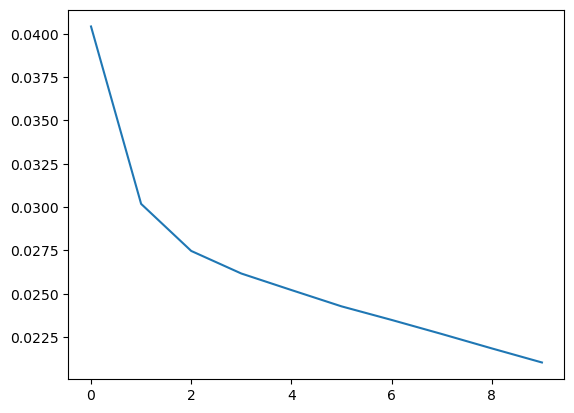

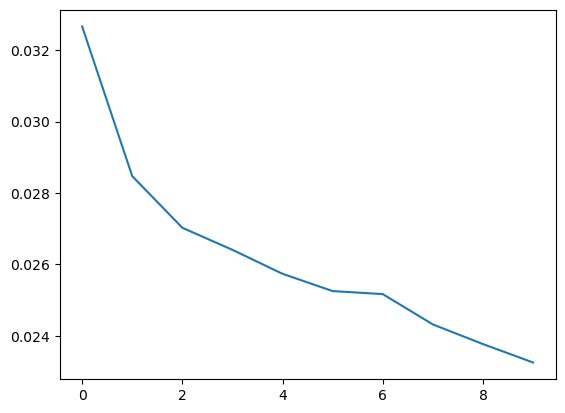

In [173]:
## WRITE YOUR CODE HERE:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)
early_stopping =EarlyStopping(monitor='val_loss', patience=5)
## - call model.compile() method to set up the loss and optimizer and metrics for the model training, you may use
model.compile(optimizer=keras.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])
history=model.fit(x=x_train, y=y_train,batch_size=64,epochs=10,validation_data=(x_val,y_val),verbose=1,callbacks = [early_stopping,keras.callbacks.ModelCheckpoint("RNN.keras",save_best_only=True)]) 
#  - -Save the entire model in the SavedModel format and then save only the weights of the model using 
model.save("recommender_net_model.keras")
## - - model.save_weights("recommender_net_weights.weights.h5")
model.save_weights("recommender_net_weights.weights.h5")
 
## - plot the train and validation loss
plt.plot(history.history["loss"])
plt.show()
plt.plot(history.history["val_loss"])


<details>
    <summary>Click here for Hints</summary>
    
When you are fitting a model, dont forget to specify the parameters: `x=x_train, y=y_train`, as well as `batch_size=64`, number of `epochs=10` and of course `validation_data=(x_val, y_val)` you can also define `verbose = 1` which will show you an animated progress for the training progress for each epoch.
    
* You can set  `history = model.fit()` which will give you a "loss" dataframe which will be very useful for ploting the train and validation loss. To plot it, use plt.plot() with `history.history["loss"]` as its parameter for train loss and `history.history["val_loss"]` for validation loss.


_TODO:_ Evaluate the trained model


In [49]:
x_train

array([[ 8376,    12],
       [ 7659,    29],
       [10717,     3],
       ...,
       [ 3409,    18],
       [28761,    19],
       [ 4973,    17]], dtype=int64)

In [57]:
np.shape(user_idx2id_dict)

()

In [31]:
encoded_data[encoded_data['user']==2][['user','item']].to_numpy()

array([[ 2,  2],
       [ 2, 26],
       [ 2, 39],
       [ 2, 67],
       [ 2, 34],
       [ 2, 48],
       [ 2,  4],
       [ 2, 42],
       [ 2, 37],
       [ 2, 79],
       [ 2, 29],
       [ 2, 72],
       [ 2, 21],
       [ 2, 11],
       [ 2, 98],
       [ 2, 51],
       [ 2,  7],
       [ 2, 23],
       [ 2, 12],
       [ 2, 90],
       [ 2, 41],
       [ 2, 57],
       [ 2, 94],
       [ 2, 66],
       [ 2, 17],
       [ 2,  8],
       [ 2,  5],
       [ 2, 27],
       [ 2, 49],
       [ 2, 18],
       [ 2,  6],
       [ 2,  3],
       [ 2, 61],
       [ 2, 31],
       [ 2, 56]], dtype=int64)

In [57]:
ratings_df = pd.read_csv("ratings.csv")
course_genres_df = pd.read_csv("course_genres.csv")
user_ratings = ratings_df[ratings_df['user'] == 2]
enrolled_course_ids = user_ratings['item'].to_list()
all_courses = set(course_genres_df['COURSE_ID'].values)
unknown_courses = list(all_courses.difference(enrolled_course_ids))
test_dataset= pd.DataFrame({'user':[2]*len(unknown_courses),'item':unknown_courses,'rating':[4]*len(unknown_courses)})

encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(ratings_df)
encoded_user_id=list(user_idx2id_dict.keys())[list(user_idx2id_dict.values()).index(2)]
encoded_unknown_courses=[]
for i in unknown_courses:
    if i in ratings_df.item.unique():
        encoded_unknown_courses.append(list(course_idx2id_dict.keys())[list(course_idx2id_dict.values()).index(i)])
    else:
        course_idx2id_dict[list(course_idx2id_dict.keys())[-1]+1]=i
        encoded_unknown_courses.append(list(course_idx2id_dict.keys())[list(course_idx2id_dict.values()).index(i)])
        
encoded_test_dataset= pd.DataFrame({'user':[encoded_user_id]*len(encoded_unknown_courses),'item':encoded_unknown_courses,'rating':[4]*len(encoded_unknown_courses)})

In [ ]:
encoded_test_dataset.sort_values(by='rating',inplace=True)

,user,item,rating
0,4818,138,4
1,4818,139,4
2,4818,129,4
3,4818,140,4
4,4818,141,4
...,...,...,...
241,4818,304,4
242,4818,305,4
243,4818,306,4
244,4818,80,4


In [59]:
y_pred=model.predict(encoded_test_dataset[['user','item']].to_numpy())

InvalidArgumentError: Graph execution error:

Detected at node recommender_net_1_1/item_bias_1/GatherV2 defined at (most recent call last):
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\runpy.py", line 197, in _run_module_as_main

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\runpy.py", line 87, in _run_code

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\asyncio\base_events.py", line 601, in run_forever

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\asyncio\base_events.py", line 1905, in _run_once

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\Vishal\AppData\Local\Temp\ipykernel_25076\391611790.py", line 1, in <module>

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 566, in predict

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 260, in one_step_on_data_distributed

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 250, in one_step_on_data

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 107, in predict_step

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\Vishal\AppData\Local\Temp\ipykernel_25076\719585780.py", line 98, in call

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\layers\core\embedding.py", line 150, in call

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\ops\numpy.py", line 5581, in take

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2274, in take

indices[0] = 138 is not in [0, 126)
	 [[{{node recommender_net_1_1/item_bias_1/GatherV2}}]] [Op:__inference_one_step_on_data_distributed_95278]

In [52]:
np.shape(encoded_data[encoded_data['user']==2][['user','item']].to_numpy())

(35, 2)

In [53]:
np.shape(x_train)

(186644, 2)

In [25]:
(y_pred*2)+3

array([[4.129721 ],
       [4.1394806],
       [4.117153 ],
       [4.1138372],
       [4.1268735],
       [4.1601696],
       [4.130589 ],
       [4.0948315],
       [4.129633 ],
       [4.1021376],
       [4.1142044],
       [4.11471  ],
       [4.09359  ],
       [4.129404 ],
       [4.1473503],
       [4.136633 ],
       [4.1234684],
       [4.1242385],
       [4.1378217],
       [4.1453505],
       [4.10397  ],
       [4.1161284],
       [4.1273904],
       [4.117607 ],
       [4.109945 ],
       [4.1307654],
       [4.100795 ],
       [4.1266975],
       [4.168638 ],
       [4.1250787],
       [4.126605 ],
       [4.1167984],
       [4.1348476],
       [4.157608 ],
       [4.1694584]], dtype=float32)

In [45]:
encoded_data

,user,item,rating
0,0,0,5
1,1,1,3
2,2,2,5
3,3,3,5
4,4,4,3
...,...,...,...
233301,9938,4,5
233302,6421,23,5
233303,9138,60,3
233304,8410,8,4


In [ ]:
encoded_data, user_idx2id_dict, course_idx2id_dict

In [ ]:
list(course_idx2id_dict.keys())[-1]

126

In [46]:
course_idx2id_dict

{0: 'CC0101EN',
 1: 'CL0101EN',
 2: 'ML0120ENv3',
 3: 'BD0211EN',
 4: 'DS0101EN',
 5: 'ST0101EN',
 6: 'DS0301EN',
 7: 'DS0105EN',
 8: 'BD0141EN',
 9: 'CO0201EN',
 10: 'CB0103EN',
 11: 'DV0101EN',
 12: 'DS0103EN',
 13: 'BD0123EN',
 14: 'BC0101EN',
 15: 'TA0105EN',
 16: 'ML0151EN',
 17: 'BD0101EN',
 18: 'BD0111EN',
 19: 'BC0201EN',
 20: 'ML0122ENv1',
 21: 'BD0131EN',
 22: 'BD0121EN',
 23: 'PY0101EN',
 24: 'BD0145EN',
 25: 'ML0101EN',
 26: 'CO0301EN',
 27: 'ML0101ENv3',
 28: 'DB0151EN',
 29: 'CO0101EN',
 30: 'RP0101EN',
 31: 'SC0101EN',
 32: 'PA0101EN',
 33: 'LB0101ENv1',
 34: 'ML0103EN',
 35: 'CC0150EN',
 36: 'DS0110EN',
 37: 'DA0101EN',
 38: 'ML0122EN',
 39: 'ML0115EN',
 40: 'ML0111EN',
 41: 'ML0109EN',
 42: 'BD0223EN',
 43: 'BC0202EN',
 44: 'CC0103EN',
 45: 'COM001EN',
 46: 'DB0101EN',
 47: 'CNSC02EN',
 48: 'DV0151EN',
 49: 'RP0105EN',
 50: 'LB0109ENv1',
 51: 'SC0105EN',
 52: 'RP0103',
 53: 'WA0101EN',
 54: 'RAVSCTEST1',
 55: 'RP0151EN',
 56: 'CO0401EN',
 57: 'SC0103EN',
 58: 'LB0111EN

In [26]:
encoded_data.user.map(user_idx2id_dict)

0         1889878
1         1342067
2         1990814
3          380098
4          779563
           ...   
233301    1540125
233302    1250651
233303    1003832
233304     922065
233305    1596120
Name: user, Length: 233306, dtype: int64

In [44]:
list(user_idx2id_dict.keys())[list(user_idx2id_dict.values()).index(2)]

4818

In [42]:
user_idx2id_dict

{0: 1889878,
 1: 1342067,
 2: 1990814,
 3: 380098,
 4: 779563,
 5: 1390655,
 6: 367075,
 7: 1858700,
 8: 600100,
 9: 623377,
 10: 766893,
 11: 1248617,
 12: 1633385,
 13: 1706535,
 14: 1804498,
 15: 1474302,
 16: 1602482,
 17: 301887,
 18: 633216,
 19: 1794016,
 20: 2098743,
 21: 1143622,
 22: 1007849,
 23: 1555457,
 24: 946915,
 25: 892274,
 26: 551690,
 27: 750076,
 28: 789341,
 29: 773165,
 30: 794886,
 31: 1342117,
 32: 640330,
 33: 1034313,
 34: 961488,
 35: 1246308,
 36: 979308,
 37: 634975,
 38: 1383971,
 39: 685972,
 40: 630451,
 41: 1516838,
 42: 1132926,
 43: 1281219,
 44: 1741605,
 45: 526671,
 46: 1319023,
 47: 1208933,
 48: 784113,
 49: 1470621,
 50: 1261677,
 51: 687207,
 52: 990745,
 53: 1624397,
 54: 735157,
 55: 972170,
 56: 876477,
 57: 1448499,
 58: 674478,
 59: 1543855,
 60: 975617,
 61: 1205605,
 62: 1033776,
 63: 640160,
 64: 266643,
 65: 1360597,
 66: 1148660,
 67: 557100,
 68: 604450,
 69: 300554,
 70: 943707,
 71: 83447,
 72: 763941,
 73: 1802609,
 74: 922120,


In [62]:
### WRITE YOUR CODE HERE

### - call model.evaluate() to evaluate the model
model.evaluate(x=x_test,y=y_test)

y_pred=model.predict(x_test)
from sklearn.metrics import root_mean_squared_error
print(root_mean_squared_error(y_true=(y_test*2)+3,y_pred=np.round((y_pred*2)+3)))

730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - loss: 0.1698 - root_mean_squared_error: 0.4105
730/730 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
0.8134462126672308


In [63]:

print(root_mean_squared_error(y_true=(y_test*2)+3,y_pred=np.full(len(y_test),4)))

0.8134462126672308


In [127]:
y_rand=np.random.randint(3,6,size=len(y_test))
print(root_mean_squared_error(y_true=(y_test*2)+3,y_pred=y_rand))

1.1500512928053785


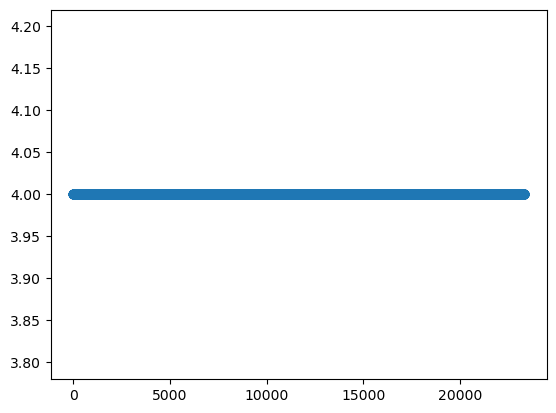

In [64]:
plt.scatter(range(len(y_pred)),np.round((y_pred*2)+3))

In [65]:
len(y_pred)

23331

In [66]:
len(y_test)

23331

In [67]:
np.unique(np.round((y_pred*2)+3))

array([4.], dtype=float32)

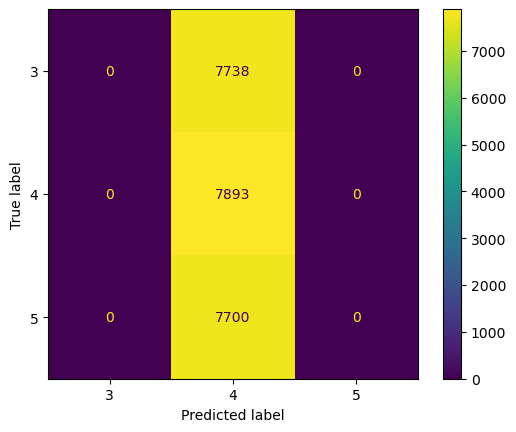

In [68]:
ConfusionMatrixDisplay.from_predictions(y_true=(y_test*2)+3,y_pred=np.round((y_pred*2)+3),labels=[3,4,5])

In [ ]:
import keras_tuner as kt


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe=OneHotEncoder()
OHE=ohe.fit_transform(x_train[:,0].reshape(-1, 1))

In [ ]:
x_train_users=pd.get_dummies(x_train[:,0])
x_train_items=pd.get_dummies(x_train[:,1])

x_val_users=pd.get_dummies(x_val[:,0])
x_val_items=pd.get_dummies(x_val[:,1])

x_test_users=pd.get_dummies(x_test[:,0])
x_test_items=pd.get_dummies(x_test[:,1])

In [ ]:
encoded_data

,user,item,rating
0,0,0,5
1,1,1,3
2,2,2,5
3,3,3,5
4,4,4,3
...,...,...,...
233301,9938,4,5
233302,6421,23,5
233303,9138,60,3
233304,8410,8,4


In [ ]:
#dummy_users=pd.get_dummies(encoded_data.loc[:,'user'].values)
#dummy_items=pd.get_dummies(encoded_data.loc[:,'item'].values)
dummy_users=encoded_data.loc[:,'user'].values
dummy_items=encoded_data.loc[:,'item'].values
ratings=encoded_data.loc[:,'rating'].values

train_indices = int(0.8 * encoded_data.shape[0])
test_indices = int(0.9 * encoded_data.shape[0])
# Assigning subsets of features and labels for each set
x_train_users, x_val_users, x_test_users,x_train_items, x_val_items, x_test_items=(#,y_train, y_val, y_test = (
    dummy_users[:train_indices], # Training features
    dummy_users[train_indices:test_indices], # Validation features
    dummy_users[test_indices:], # Testing features
    
    dummy_items[:train_indices], # Training features
    dummy_items[train_indices:test_indices], # Validation features
    dummy_items[test_indices:], # Testing features
    
    #ratings[:train_indices], # Training labels
   # ratings[train_indices:test_indices], # Validation labels
    #ratings[test_indices:], # Testing labels
)

In [ ]:
def DNN_model_builder(hp):

    hp_units = hp.Int('units', min_value=8, max_value=32, step=8)
    hp_l2 = hp.Choice('ridge', values=[1e-1,1e-2, 1e-3,1e-4])
    hp_drop = hp.Float('dropout',min_value=0.05,max_value=0.9,step=0.05)
    

    inputs_users = tf.keras.Input(shape=(1,))
    inputs_items = tf.keras.Input(shape=(1,))
    
    embedding_user = tf.keras.layers.Embedding(1,embedding_size)(inputs_users)
    embedding_item = tf.keras.layers.Embedding(1,embedding_size)(inputs_items)
    
    x = tf.keras.layers.Flatten()(embedding_user)
    x = tf.keras.layers.Dense(units=hp_units,kernel_regularizer=tf.keras.regularizers.L2(l2=hp_l2))(x)
    x = tf.keras.layers.Dropout(hp_drop)(x)
    
    y = tf.keras.layers.Flatten()(embedding_item)
    y = tf.keras.layers.Dense(units=hp_units,kernel_regularizer=tf.keras.regularizers.L2(l2=hp_l2))(y)
    y = tf.keras.layers.Dropout(hp_drop)(y)
    
    outputs = tf.keras.layers.Dot(axes=1)([x, y])
    outputs = tf.keras.layers.Dense(1,activation='relu')(outputs)

    model = tf.keras.Model(inputs=(inputs_users,inputs_items),outputs=outputs)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e0,1e-1,1e-2, 1e-3,1e-4,1e-5])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
#=============================Setup================================#
# Create Tuner 
tuner = kt.Hyperband(DNN_model_builder,
                     objective=kt.Objective("val_rmse", direction="min"),
                     max_epochs=20,
                     factor=3,
                     directory='my_ann',
                     project_name='ANN'
                    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Tune
tuner.search((x_train_users,x_train_items),y_train,validation_data=((x_val_users,x_val_items),y_val), epochs=100, callbacks=[stop_early])

#===================Get best hyperparams and rebuild=====================#

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}
""")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit((x_train_users,x_train_items),y_train, epochs=100,validation_data=((x_val_users,x_val_items),y_val))

val_acc_per_epoch = history.history['val_rmse']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

#===================Get best epoch and rebuild=====================#

#Rebuild with best params
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
hypermodel.fit((x_train_users,x_train_items),y_train, epochs=best_epoch,validation_data=((x_val_users,x_val_items),y_val))
# Print results
eval_result_train = hypermodel.evaluate((x_train_users,x_train_items),y_train)
print("[test loss, test mae]:", eval_result_train)
eval_result_val = hypermodel.evaluate((x_val_users,x_val_items),y_val)
print("[test loss, test mae]:", eval_result_val)
eval_result_test = hypermodel.evaluate((x_test_users,x_test_items),y_test)
print("[test loss, test mae]:", eval_result_test)

Reloading Tuner from my_ann\ANN\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
16                |32                |units
0.1               |0.001             |ridge
0.4               |0.4               |dropout
0.01              |0.1               |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


Traceback (most recent call last):
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\tensorflow\python\eager\execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node functional_1/embedding_2/GatherV2 defined at (most recent call last):
  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\runpy.py", line 197, in _run_module_as_main

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\runpy.py", line 87, in _run_code

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\asyncio\base_events.py", line 601, in run_forever

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\asyncio\base_events.py", line 1905, in _run_once

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\Vishal\AppData\Local\Temp\ipykernel_21628\3137367848.py", line 14, in <module>

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 234, in search

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 58, in train_step

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\ops\function.py", line 177, in _run_through_graph

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\models\functional.py", line 648, in call

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\layers\core\embedding.py", line 150, in call

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\ops\numpy.py", line 5581, in take

  File "c:\Users\Vishal\anaconda3\envs\tf-with_some_pip\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 2274, in take

indices[0,0] = 28549 is not in [0, 1)
	 [[{{node functional_1/embedding_2/GatherV2}}]] [Op:__inference_multi_step_on_iterator_1369275]


<details>
    <summary>Click here for Hints</summary>
    
Use `x_test, y_test` as parameters for `model.evaluate()`


### Extract the user and item embedding vectors as latent feature vectors


Now, we have trained the `RecommenderNet()` model and it can predict the ratings with relatively small RMSE. 

If we print the trained model then we can see its layers and their parameters/weights.


In [ ]:
model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ (None, 16)             │       542,416 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ (None, 1)              │        33,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ (None, 16)             │         2,016 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,379 (6.62 MB)

 Trainable params: 578,459 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156,920 (4.41 MB)

In the `RecommenderNet`, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by `RecommenderNet` and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [21]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 32)


In [22]:
user_latent_features[0]

array([ 0.10066096, -0.00595355, -0.02704426, -0.00933237, -0.03083269,
       -0.03164659,  0.05474936,  0.05192786,  0.03752008, -0.01831072,
       -0.00743131,  0.0151819 ,  0.00061353, -0.07436116, -0.00729055,
        0.00308659,  0.12156511, -0.05803119,  0.00279145, -0.04083279,
        0.10231543,  0.03934538,  0.07929967,  0.05557961, -0.02325429,
       -0.0732898 ,  0.0067431 , -0.05032746, -0.01022252,  0.06096746,
        0.01722313,  0.07192267], dtype=float32)

In [23]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 32)


In [24]:
item_latent_features[0]

array([-0.05435259, -0.09313135, -0.07966703, -0.03121574,  0.0113577 ,
        0.02922287, -0.02080836,  0.06998389, -0.00499691,  0.01197218,
        0.06038477, -0.01362123, -0.07999691,  0.12566994, -0.05642088,
       -0.09255175, -0.05324035,  0.10041624,  0.07492191,  0.01089256,
        0.01789915, -0.12086885,  0.20311747, -0.02889192, -0.1313925 ,
       -0.05599772,  0.09936925,  0.04567591,  0.00488509, -0.07850805,
       -0.02619259, -0.0273379 ], dtype=float32)

In [28]:
user_latent_features.nbytes

4339328

Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


### TASK (Optional): Customize the RecommenderNet to potentially improve the model performance


The pre-defined `RecommenderNet()` is a actually very basic neural network, you are encouraged to customize it to see if model prediction performance will be improved. Here are some directions:
- Hyperparameter tuning, such as the embedding layer dimensions
- Add more hidden layers
- Try different activation functions such as `ReLu`


In [ ]:
## WRITE YOUR CODE HERE

## Update RecommenderNet() class

## compile and fit the updated model

## evaluate the updated model


In [134]:
Res=pd.DataFrame({
    'All_Pred_4':[0.8134462126672308],
    'All_random':[1.1500512928053785],
    'neural network':[0.8134462126672308],
    'KNN':[0.8193526197106108],
    'NMF':[0.9128657876966813],
    'logistic':[1.191178],
    'random_forest':[1.152355],
    'svm':[1.153508],
    'xgboost':[1.151121]
 }).T
Res.reset_index(inplace=True)
Res.rename(columns={'index':'Algorithm',0:'RMSE'},inplace=True)
Res.sort_values(by='RMSE',inplace=True)

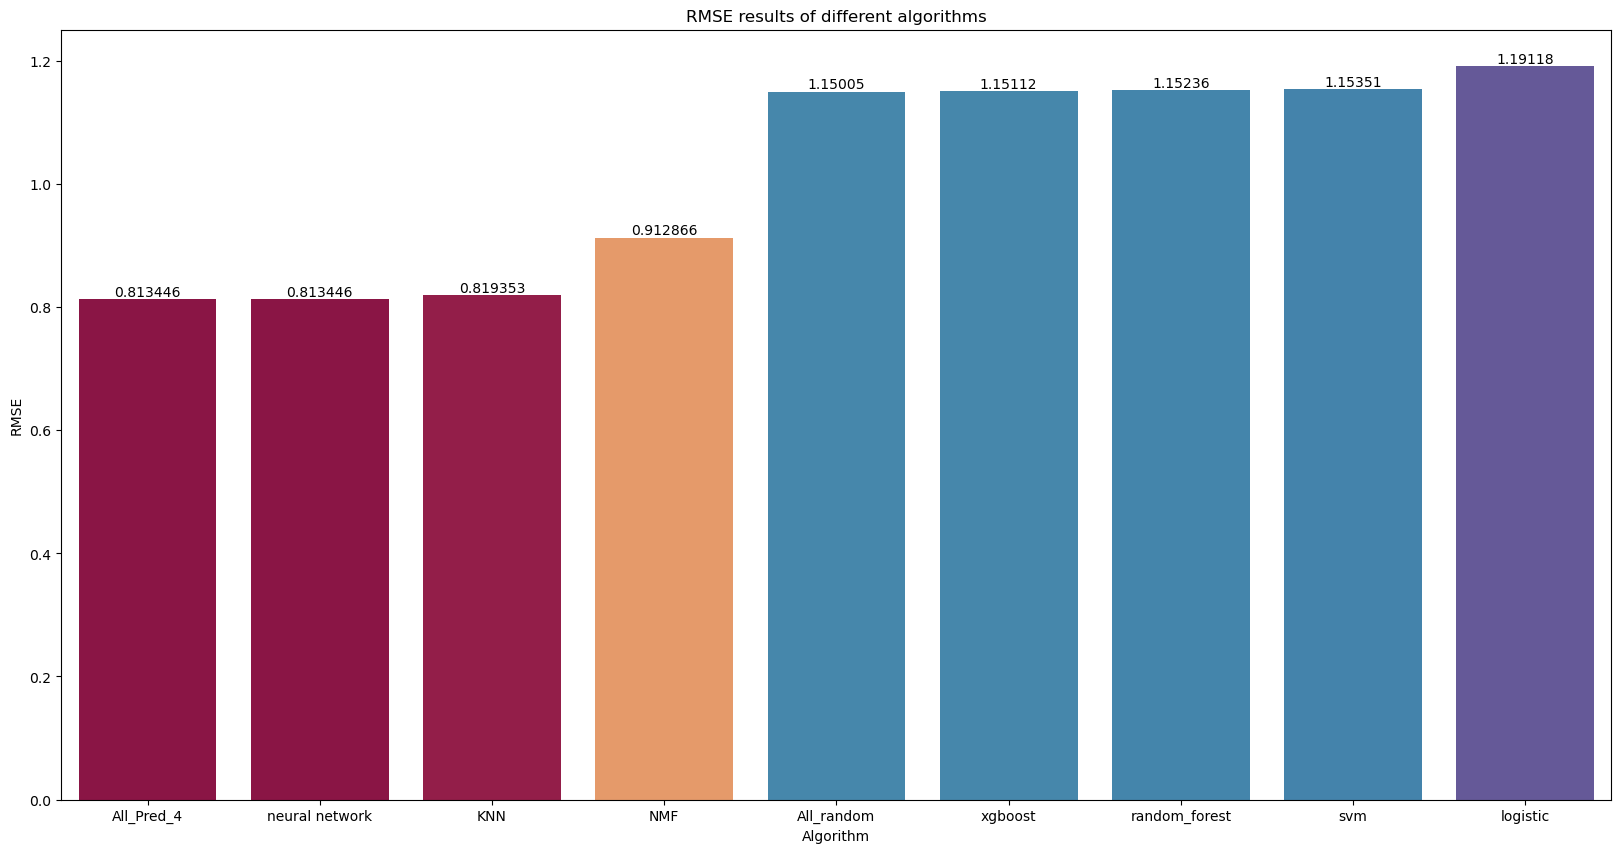

In [135]:
import seaborn as sns
plt.figure(figsize=[20,10])
ax=sns.barplot(data =Res,x='Algorithm', y='RMSE', hue='RMSE',palette='Spectral')
for i in range(8):
    ax.bar_label(ax.containers[i], fontsize=10)
ax.set_title('RMSE results of different algorithms')
ax.get_legend().remove()

In [65]:
user_latent_features[0]

array([[-9.3937526e-03, -2.1910816e-02,  8.2886264e-02, ...,
        -5.6402724e-02,  8.9289900e-03, -2.8311359e-02],
       [-2.0426404e-04, -5.5834945e-02, -4.0131267e-02, ...,
         3.2828018e-02, -3.6412794e-02, -1.6237745e-02],
       [ 5.7718545e-02, -5.4035122e-03,  8.2113944e-02, ...,
        -9.5057432e-03,  3.9272633e-04,  5.9878077e-02],
       ...,
       [ 4.6054353e-30, -4.5063439e-30, -4.5515792e-30, ...,
        -4.5635433e-30,  4.5876832e-30, -4.5006350e-30],
       [ 5.9442795e-03, -5.6608906e-03, -3.0131892e-03, ...,
         1.2194063e-02, -6.0504288e-03, -4.6807886e-03],
       [-2.0296425e-02, -7.7170139e-04,  9.8617924e-03, ...,
        -2.6284226e-03,  2.0107225e-02,  7.2049927e-03]], dtype=float32)

In [162]:
ratings_df = pd.read_csv("ratings.csv")
course_genres_df = pd.read_csv("course_genres.csv")
user_ratings = ratings_df[ratings_df['user'] == 2]
enrolled_course_ids = user_ratings['item'].to_list()
all_courses = set(course_genres_df['COURSE_ID'].values)
unknown_courses = list(all_courses.difference(enrolled_course_ids))
test_dataset= pd.DataFrame({'user':[2]*len(unknown_courses),'item':unknown_courses,'rating':[4]*len(unknown_courses)})
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(ratings_df)
encoded_user_id=list(user_idx2id_dict.keys())[list(user_idx2id_dict.values()).index(2)]
num_users = len(user_idx2id_dict)
num_items = len(course_idx2id_dict)

In [151]:
len(ratings_df['user'].unique())

33925

In [152]:
len(list(user_idx2id_dict))

33925

In [153]:
user_latent_features.shape

(33925, 33)

In [154]:
np.unique(x_train[:, 0])

array([    0,     1,     2, ..., 33922, 33923, 33924], dtype=int64)

In [155]:
encoded_data['user'].unique()

array([    0,     1,     2, ..., 33922, 33923, 33924], dtype=int64)

In [156]:
user_latent_features.shape

(33925, 33)

In [157]:
model.get_layer('user_embedding_layer').get_weights()[0].shape

(33925, 16)

In [174]:
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
user_latent_features = pd.DataFrame(user_latent_features,columns=["User_Feature_"+str(i) for i in range(user_latent_features.shape[1])])
user_latent_features['user']=[user_idx2id_dict[i] for i in encoded_data['user'].unique()]

item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
item_latent_features = pd.DataFrame(item_latent_features,columns=["Item_Feature_"+str(i) for i in range(item_latent_features.shape[1])])
item_latent_features['item']=[course_idx2id_dict[i] for i in encoded_data['item'].unique()]

In [175]:
len(course_idx2id_dict)

138

In [176]:
len(encoded_data['item'].unique())

138

In [177]:
len(user_idx2id_dict)

33925

In [178]:
len(encoded_data['user'].unique())

33925

In [183]:
user_latent_features

,User_Feature_0,User_Feature_1,User_Feature_2,User_Feature_3,User_Feature_4,User_Feature_5,User_Feature_6,User_Feature_7,User_Feature_8,User_Feature_9,User_Feature_10,User_Feature_11,User_Feature_12,User_Feature_13,User_Feature_14,User_Feature_15,user
0,0.056236,0.027736,-0.052936,-0.036263,-2.051796e-02,0.037419,-7.863346e-02,0.089279,0.088566,0.088831,-0.055072,-0.023535,-0.077473,0.005965,-0.030055,-1.946846e-02,1889878
1,-0.044679,0.019063,-0.007513,-0.050883,1.463776e-02,0.009764,-2.047002e-02,-0.007932,-0.011196,0.016603,-0.025961,-0.040311,0.036775,-0.008540,-0.009086,-4.876759e-02,1342067
2,0.000165,0.099522,-0.108958,-0.029449,-3.522857e-02,-0.027215,-8.755670e-02,-0.007196,0.077471,0.079916,-0.009290,-0.037152,-0.053655,-0.063798,-0.057530,-4.634546e-02,1990814
3,0.023701,0.037975,-0.009552,0.063239,3.267806e-02,0.043020,-2.070611e-02,-0.030998,0.004659,0.025726,0.019648,0.050226,-0.011261,0.027273,0.041418,4.417746e-03,380098
4,-0.039402,-0.056736,-0.000487,0.012200,1.526156e-02,-0.028282,-1.325555e-02,0.012093,-0.027071,0.021141,0.014463,-0.015114,0.024842,0.000399,-0.040286,3.017390e-02,779563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33920,0.014116,-0.023147,-0.027054,0.014821,-1.251894e-02,-0.018276,3.708250e-03,-0.002595,0.015152,0.012527,-0.012212,-0.010786,-0.023738,-0.013594,-0.027048,2.391412e-02,2103059
33921,-0.002989,-0.026488,-0.012281,0.018554,-4.133494e-03,-0.001669,2.391317e-03,-0.006093,-0.000183,0.005116,0.000441,-0.000251,-0.014352,-0.001424,-0.021451,2.069624e-02,2103060
33922,-0.015166,-0.014349,-0.003435,0.004138,4.380820e-04,-0.006745,-2.168986e-03,-0.004866,-0.010462,0.007221,0.003912,0.000134,0.014607,-0.001484,-0.006405,6.886605e-09,2103061
33923,0.002298,0.006912,0.000099,-0.002423,3.751175e-07,0.000005,-1.330800e-08,0.001563,0.001036,-0.000161,-0.000074,-0.000009,-0.000050,0.000013,0.002446,-2.431445e-03,2103062


In [210]:
test_dataset= pd.DataFrame({'user':[2]*len(unknown_courses),'item':unknown_courses,'rating':[4]*len(unknown_courses)})
user_emb_merged = pd.merge(test_dataset, user_latent_features, how='outer', left_on='user', right_on='user').fillna(0)
#user_emb_merged = pd.merge(rating_df, user_latent_features, how='outer', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_latent_features, how='outer', left_on='item', right_on='item').fillna(0)

In [211]:
u_features = [f"User_Feature_{i}" for i in range(len(user_latent_features.columns)-1)] 
c_features = [f"Item_Feature_{i}" for i in range(len(item_latent_features.columns)-1)]

# Extract user embedding features
user_embeddings = merged_df[u_features]
# Extract course embedding features
course_embeddings = merged_df[c_features]
# Extract ratings
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
regression_dataset = user_embeddings + course_embeddings.values
# Rename the columns of the resulting DataFrame
regression_dataset.columns = [f"Feature{i}" for i in range(len(item_latent_features.columns)-1)]# Assuming there are 16 features
# Add the 'rating' column from the original DataFrame to the regression dataset
regression_dataset['rating'] = ratings

In [212]:
regression_dataset

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
1,0.051561,0.122253,0.045909,0.034260,-0.173182,-0.069053,0.136365,-0.010437,0.035032,-0.144644,0.013159,-0.027133,-0.017048,-0.055346,0.128766,-0.085253,4.0
2,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
3,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
4,0.053486,0.114901,0.048194,0.034343,-0.180605,-0.075245,0.135084,-0.016905,0.039273,-0.146762,0.010013,-0.026118,-0.019457,-0.053591,0.125881,-0.089111,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34226,0.039134,0.026331,0.021559,0.026329,-0.127802,-0.115558,0.112440,0.094212,0.031114,-0.040428,-0.153198,-0.000994,-0.028519,-0.015443,-0.038772,-0.080868,0.0
34227,0.089884,0.076292,0.024693,-0.068509,0.083504,-0.023105,0.063192,0.125437,0.058320,-0.119896,-0.005968,-0.005857,-0.138673,0.069097,0.055267,0.076856,0.0
34228,0.107263,-0.030869,0.008350,-0.147812,0.067793,-0.011148,-0.008107,0.060018,-0.075783,0.070681,0.142362,-0.012412,0.075369,-0.126904,0.049242,0.133522,0.0
34229,-0.011688,0.026427,0.003689,-0.026048,-0.176500,0.109893,-0.090517,-0.033649,-0.128526,-0.022405,-0.067933,-0.050485,-0.075974,0.021870,0.120764,0.005154,0.0


In [213]:
user_latent_features[user_latent_features['user']==2]

,User_Feature_0,User_Feature_1,User_Feature_2,User_Feature_3,User_Feature_4,User_Feature_5,User_Feature_6,User_Feature_7,User_Feature_8,User_Feature_9,User_Feature_10,User_Feature_11,User_Feature_12,User_Feature_13,User_Feature_14,User_Feature_15,user
4818,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.01946,-0.056794,0.125795,-0.089297,2


In [216]:
regression_dataset.iloc[merged_df[(merged_df['user']==2)&(merged_df['item'].isin(unknown_courses))].index]

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
1,0.051561,0.122253,0.045909,0.034260,-0.173182,-0.069053,0.136365,-0.010437,0.035032,-0.144644,0.013159,-0.027133,-0.017048,-0.055346,0.128766,-0.085253,4.0
2,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
3,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
4,0.053486,0.114901,0.048194,0.034343,-0.180605,-0.075245,0.135084,-0.016905,0.039273,-0.146762,0.010013,-0.026118,-0.019457,-0.053591,0.125881,-0.089111,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
242,0.137147,0.135362,0.145359,-0.173008,-0.275489,-0.105879,0.100701,0.004812,0.058184,-0.095956,0.126445,-0.116109,-0.036130,-0.229303,0.157230,-0.039903,4.0
243,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0
244,0.052291,0.114901,0.047517,0.034348,-0.182523,-0.068898,0.134075,-0.016922,0.039254,-0.146742,0.011019,-0.027047,-0.019460,-0.056794,0.125795,-0.089297,4.0


In [220]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from xgboost import XGBClassifier
import scipy

In [230]:
ratings_df = pd.read_csv("ratings.csv")
course_genres_df = pd.read_csv("course_genres.csv")
user_ratings = ratings_df[ratings_df['user'] == 2]
enrolled_course_ids = user_ratings['item'].to_list()
all_courses = set(course_genres_df['COURSE_ID'].values)
unknown_courses = list(all_courses.difference(enrolled_course_ids))
test_dataset= pd.DataFrame({'user':[2]*len(unknown_courses),'item':unknown_courses,'rating':[4]*len(unknown_courses)})

# Merge user embedding features
user_emb_merged = pd.merge(ratings_df, user_latent_features, how='left', left_on='user', right_on='user').fillna(0)
merged_df = pd.merge(user_emb_merged, item_latent_features, how='left', left_on='item', right_on='item').fillna(0)
# Define column names for user and course embedding features
u_features = [f"User_Feature_{i}" for i in range(len(user_latent_features.columns)-1)] 
c_features = [f"Item_Feature_{i}" for i in range(len(item_latent_features.columns)-1)]
# Extract user embedding features
user_embeddings = merged_df[u_features]
# Extract course embedding features
course_embeddings = merged_df[c_features]
# Extract ratings
ratings = merged_df['rating']
# Aggregate the two feature columns using element-wise add
interaction_dataset = user_embeddings + course_embeddings.values
# Rename the columns of the resulting DataFrame
interaction_dataset.columns = [f"Feature{i}" for i in range(len(item_latent_features.columns)-1)]# Assuming there are 16 features
# Add the 'rating' column from the original DataFrame to the regression dataset
interaction_dataset['rating'] = ratings

X = interaction_dataset.iloc[:, :-1]
y = interaction_dataset.iloc[:, -1].values-3
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=123)



model = XGBClassifier(n_jobs=-1,random_state=123)
parameters = {
    'reg_alpha': scipy.stats.loguniform(10**-10,10**1),
    'reg_lambda': scipy.stats.loguniform(10**-10,10**3),
    'gamma': scipy.stats.loguniform(10**-10,10**1),}

model_cv=RandomizedSearchCV(estimator=model,param_distributions=parameters,n_iter=500,scoring='balanced_accuracy',n_jobs=-1,cv=3)
model_cv.fit(x_train,y_train)


model.set_params(**model_cv.best_params_)


model.fit(X,y)

# Merge user embedding features
user_emb_merged = pd.merge(test_dataset, user_latent_features, how='left', left_on='user', right_on='user').fillna(0)
merged_df = pd.merge(user_emb_merged, item_latent_features, how='left', left_on='item', right_on='item').fillna(0)
# Define column names for user and course embedding features
#u_features = [f"User_Feature_{i}" for i in range(len(user_latent_features.columns)-1)] 
#c_features = [f"Item_Feature_{i}" for i in range(len(item_latent_features.columns)-1)]
# Extract user embedding features
user_embeddings = merged_df[u_features]
# Extract course embedding features
course_embeddings = merged_df[c_features]
# Extract ratings
ratings = merged_df['rating']
# Aggregate the two feature columns using element-wise add
interaction_dataset = user_embeddings + course_embeddings.values
# Rename the columns of the resulting DataFrame
interaction_dataset.columns = [f"Feature{i}" for i in range(len(item_latent_features.columns)-1)]# Assuming there are 16 features
# Add the 'rating' column from the original DataFrame to the regression dataset
interaction_dataset['rating'] = ratings
test_data = interaction_dataset.iloc[:, :-1]
#y = regression_dataset.iloc[:, -1]
#test_data=encoded_test_dataset[['user','item']].to_numpy()
#test_data=regression_data.iloc[merged_df[(merged_df['user']==user_id)&(merged_df['item'].isin(unknown_courses))].index,:]

pred=model.predict(test_data)


test_dataset.loc[:,'rating']=pred+3
res_df=test_dataset
res_df.sort_values(by='rating',ascending=False,inplace=True)
res_df.rename(columns={'user':'USER','item':'COURSE_ID','rating':'SCORE'},inplace=True)

KeyboardInterrupt: 

In [ ]:
interaction_dataset.rating.unique()

array([3., 2.])

In [228]:
ratings_df.rating.unique()

array([3., 2.])

### Summary


In this lab, you have learned and practiced predicting course ratings using neural networks. With a predefined and trained neural network, we can extract or embed users and items into latent feature spaces and further predict the interaction between a user and an item with the latent feature vectors.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


```toggle## Change Log
```


```toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```toggle|-|-|-|-|
```
```toggle|2021-10-25|1.0|Yan|Created the initial version|
```


Copyright © 2021 IBM Corporation. All rights reserved.
